In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress, gaussian_kde

from utils import *

sns.set(style="whitegrid")

model_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
behavior_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehVar-main/Rats"

In [2]:
# load a file
fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))
file = fit_files[0]
mat = loadmat(file, struct_as_record=False, squeeze_me=True)
data = mat['BestFit_Folds']

# get rat ID
rat_id = os.path.basename(file).split('_')[0]

# for each fold, get minimum nLL
for fold_idx in range(5):
    fold = data[fold_idx]
    
    # get minimum nLL from training data
    nll_train = fold.nLL_TrainFold
    min_nll = np.min(nll_train)
    min_idx = np.argmin(nll_train)
    
    print(f"\nFold {fold_idx}:")
    print(f"  Min nLL: {min_nll:.4f}")
    
    # get training data for fold
    train_data = fold.ratTrial_TrainFold
    
    # count valid trials
    catch_array = train_data.catch
    wait_time_array = train_data.wait_time  # It's wait_time, not waittime
    valid_mask = (catch_array == 1) & (~np.isnan(wait_time_array))
    valid_trials = np.sum(valid_mask)
    
    print(f"  Valid trials (catch=1 & wait_time not nan): {valid_trials}")
    
    # normalized nLL
    normalized_nll = min_nll / valid_trials
    print(f"  Normalized nLL: {normalized_nll:.6f}")


Fold 0:
  Min nLL: 3693.4277
  Valid trials (catch=1 & wait_time not nan): 1993
  Normalized nLL: 1.853200

Fold 1:
  Min nLL: 3450.3020
  Valid trials (catch=1 & wait_time not nan): 1929
  Normalized nLL: 1.788648

Fold 2:
  Min nLL: 3778.1844
  Valid trials (catch=1 & wait_time not nan): 2001
  Normalized nLL: 1.888148

Fold 3:
  Min nLL: 3646.4598
  Valid trials (catch=1 & wait_time not nan): 1943
  Normalized nLL: 1.876716

Fold 4:
  Min nLL: 3765.6956
  Valid trials (catch=1 & wait_time not nan): 2022
  Normalized nLL: 1.862362



Fold 0:
  Summary Statistics:
    Reward sensitivity (mixed block slope): 1.1754
    Block sensitivity (low/high ratio): 1.1205

Fold 1:
  Summary Statistics:
    Reward sensitivity (mixed block slope): 1.1866
    Block sensitivity (low/high ratio): 1.1802

Fold 2:
  Summary Statistics:
    Reward sensitivity (mixed block slope): 1.1805
    Block sensitivity (low/high ratio): 1.1262

Fold 3:
  Summary Statistics:
    Reward sensitivity (mixed block slope): 1.2481
    Block sensitivity (low/high ratio): 1.1443

Fold 4:
  Summary Statistics:
    Reward sensitivity (mixed block slope): 1.2358
    Block sensitivity (low/high ratio): 1.1264


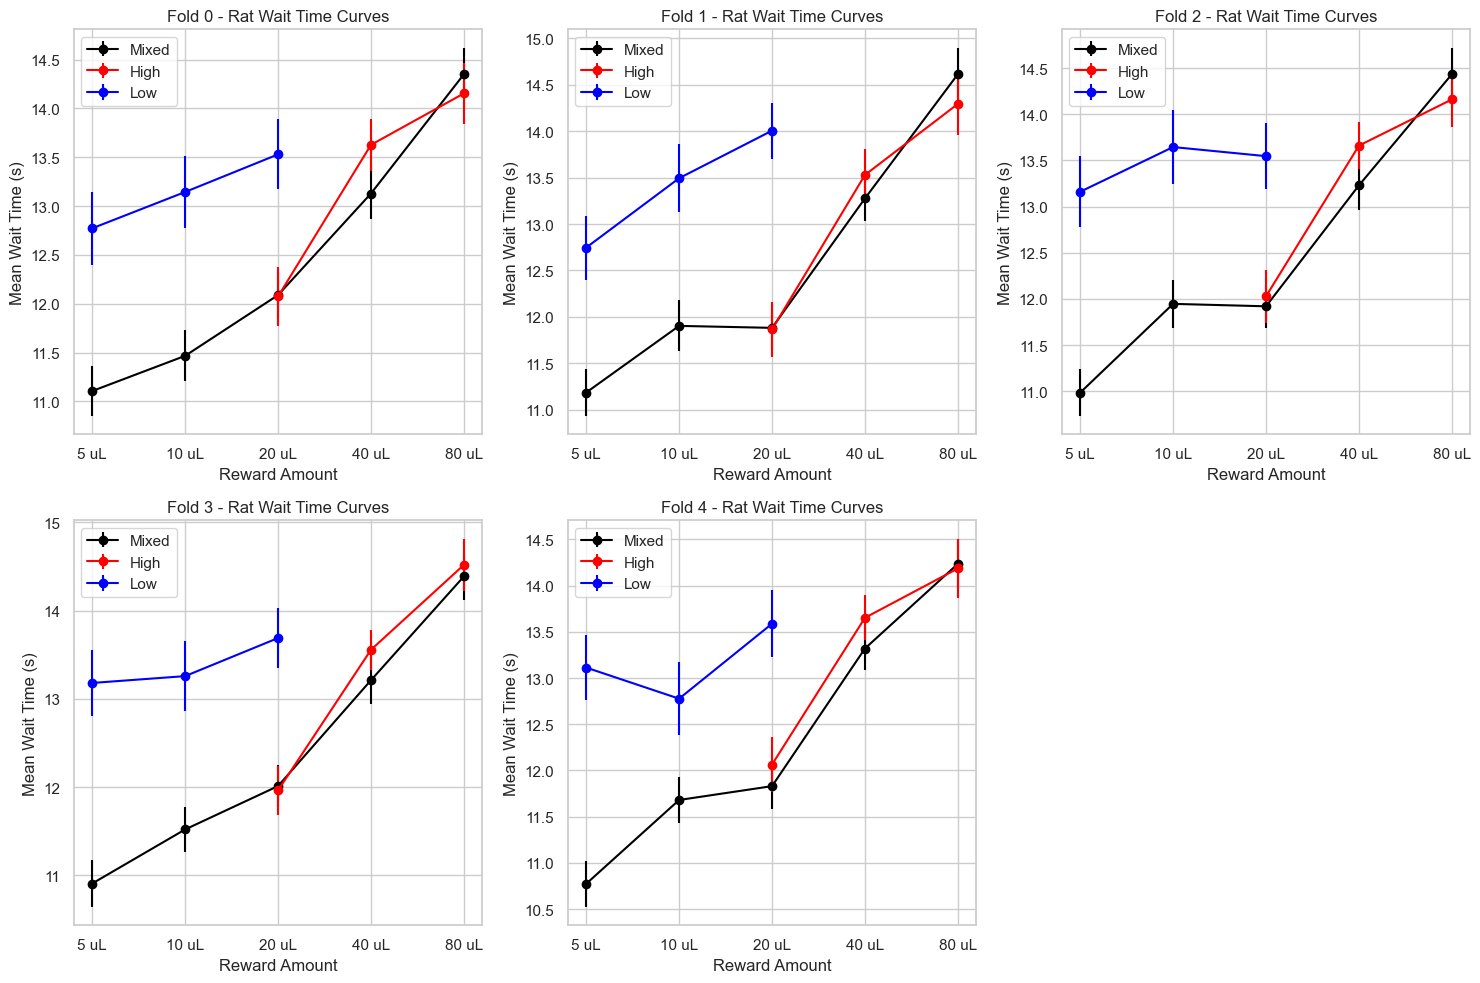

In [3]:
# store results for all folds
fold_results = []

# create figure for all fold plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for fold_idx in range(5):
    fold = data[fold_idx]
    
    print(f"\nFold {fold_idx}:")
    
    # get the training data for this fold
    train_data = fold.ratTrial_TrainFold
    
    # convert to dataframe for filtering
    df_train = pd.DataFrame({
        'reward': train_data.reward,
        'block': train_data.block,
        'wait_time': train_data.wait_time,
        'optout': train_data.optout,
        'vios': train_data.vios,
    })
    
    # apply filtering
    df_filtered = apply_valid_trial_filter(df_train)
    
    # map rewards
    unique_rewards = sorted(df_filtered['reward'].unique())   
    if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
        reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
        df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
    
    # plot wait time curves for this fold
    ax = axes[fold_idx]
    plot_aggregated_wait_times_on_ax(df_filtered, ax, 
                                     block_labels={1: 'Mixed', 2: 'High', 3: 'Low'},
                                     block_colors={1: 'black', 2: 'red', 3: 'blue'})
    ax.set_title(f'Fold {fold_idx} - Rat Wait Time Curves')
    ax.legend()
    
    # calculate wait time curves for summary stats
    reward_sizes = [5, 10, 20, 40, 80]
    wt_curves = {'mixed': [], 'high': [], 'low': []}
    
    # get wait times for each reward in each block type
    for rew in reward_sizes:
        # mixed block (block 1)
        mixed_wt = df_filtered[(df_filtered['block'] == 1) & (df_filtered['reward'] == rew)]['wait_time'].mean()
        wt_curves['mixed'].append(mixed_wt)
        
        # high block (block 2)
        high_wt = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == rew)]['wait_time'].mean()
        wt_curves['high'].append(high_wt)
        
        # low block (block 3)
        low_wt = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == rew)]['wait_time'].mean()
        wt_curves['low'].append(low_wt)
    
    # calculate reward sensitivity (slope of mixed block)
    valid_idx = ~np.isnan(wt_curves['mixed'])
    if np.sum(valid_idx) > 1:
        valid_rewards = np.log(np.array(reward_sizes)[valid_idx])
        valid_wt = np.array(wt_curves['mixed'])[valid_idx]
        slope, _, _, _, _ = linregress(valid_rewards, valid_wt)
        rew_sensitivity = slope
    else:
        rew_sensitivity = np.nan
    
    # calculate block sensitivity (ratio of low to high at 20uL)
    idx_20 = reward_sizes.index(20)
    if not np.isnan(wt_curves['low'][idx_20]) and not np.isnan(wt_curves['high'][idx_20]):
        block_sensitivity = wt_curves['low'][idx_20] / wt_curves['high'][idx_20]
    else:
        block_sensitivity = np.nan
    
    print(f"  Summary Statistics:")
    print(f"    Reward sensitivity (mixed block slope): {rew_sensitivity:.4f}")
    print(f"    Block sensitivity (low/high ratio): {block_sensitivity:.4f}")
    
    # store results
    fold_results.append({
        'fold': fold_idx,
        'wt_curves': wt_curves,
        'rew_sensitivity': rew_sensitivity,
        'block_sensitivity': block_sensitivity
    })

axes[-1].remove()

plt.tight_layout()
plt.show()


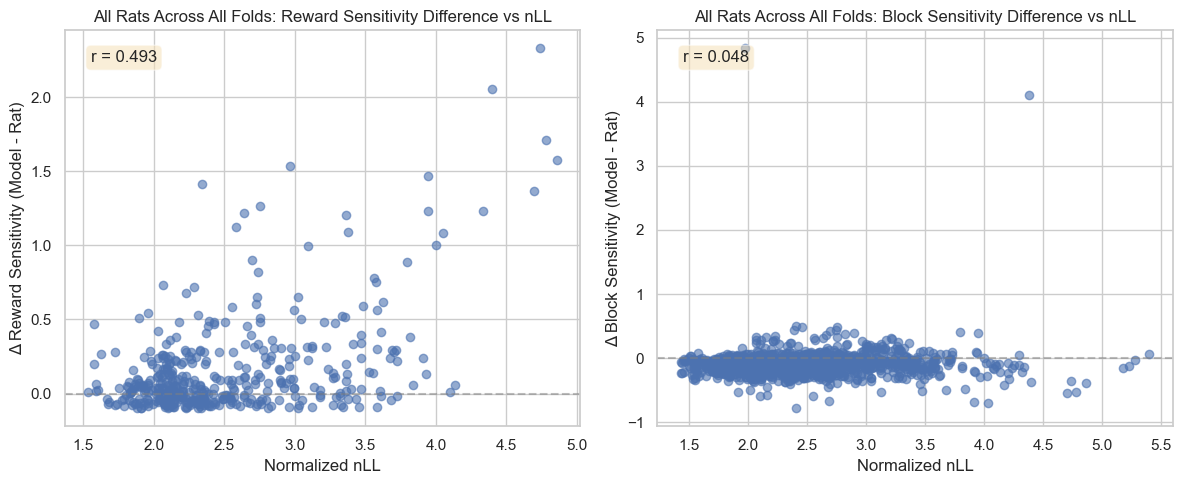

Correlation between nLL and Δ Reward Sensitivity: 0.4927
Correlation between nLL and Δ Block Sensitivity: 0.0479


In [4]:
# lists to store all data points
all_nll = []
all_delta_rew = []
all_delta_block = []
rat_ids = []

# loop through all fit files
fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))

for file in fit_files:
    rat_id = os.path.basename(file).split('_')[0]
    
    # load the fit file
    mat = loadmat(file, struct_as_record=False, squeeze_me=True)
    data = mat['BestFit_Folds']
    
    # process each fold
    for fold_idx in range(5):
        fold = data[fold_idx]
        
        # get normalized nLL
        nll_train = fold.nLL_TrainFold
        min_nll = np.min(nll_train)
        train_data = fold.ratTrial_TrainFold
        catch_array = train_data.catch
        wait_time_array = train_data.wait_time
        valid_mask = (catch_array == 1) & (~np.isnan(wait_time_array))
        valid_trials = np.sum(valid_mask)
        normalized_nll = min_nll / valid_trials
        
        # get model wait times from BestFit
        bestfit = fold.BestFit
        model_wait_times = bestfit.Train.WTOpt
        
        # create dataframe with model predictions
        df_train = pd.DataFrame({
            'reward': train_data.reward,
            'block': train_data.block,
            'wait_time': train_data.wait_time,
            'model_wait_time': model_wait_times,
            'optout': train_data.optout,
            'vios': train_data.vios,
        })
        
        # apply filtering to rat and model data
        df_filtered = apply_valid_trial_filter(df_train)
        
        # map rewards
        unique_rewards = sorted(df_filtered['reward'].unique())
        if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
            reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
            df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
        
        # Calculate rat stats
        mixed_data = df_filtered[df_filtered['block'] == 1]
        reward_sizes = [5, 10, 20, 40, 80]
        
        # rat reward sensitivity
        rat_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['wait_time'].mean()
            rat_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(rat_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(rat_mean_wt)[valid_idx])
            rat_rew_sensitivity = slope
        else:
            rat_rew_sensitivity = np.nan
        
        # rat block sensitivity
        low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        rat_block_sensitivity = low_20 / high_20 if high_20 > 0 else np.nan
        
        # calculate model stats
        # model reward sensitivity
        model_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['model_wait_time'].mean()
            model_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(model_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(model_mean_wt)[valid_idx])
            model_rew_sensitivity = slope
        else:
            model_rew_sensitivity = np.nan
        
        # model block sensitivity
        model_low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_block_sensitivity = model_low_20 / model_high_20 if model_high_20 > 0 else np.nan
        
        # calculate differences
        delta_rew = model_rew_sensitivity - rat_rew_sensitivity
        delta_block = model_block_sensitivity - rat_block_sensitivity
        
        # store results
        all_nll.append(normalized_nll)
        all_delta_rew.append(delta_rew)
        all_delta_block.append(delta_block)
        rat_ids.append(rat_id)

# make combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# remove any NaN values for correlation calculation
valid_rew = ~(np.isnan(all_nll) | np.isnan(all_delta_rew))
valid_block = ~(np.isnan(all_nll) | np.isnan(all_delta_block))

# Plot 1: Delta Reward Sensitivity
all_delta_rew_array = np.array(all_delta_rew)
rew_range_mask = (all_delta_rew_array >= -0.1) & (all_delta_rew_array <= 3.1)
combined_mask = valid_rew & rew_range_mask

ax1.scatter(np.array(all_nll)[combined_mask], np.array(all_delta_rew)[combined_mask], alpha=0.6)
ax1.set_xlabel('Normalized nLL')
ax1.set_ylabel('Δ Reward Sensitivity (Model - Rat)')
ax1.set_title('All Rats Across All Folds: Reward Sensitivity Difference vs nLL')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# calculate and show correlation
if np.sum(combined_mask) > 2:
    corr_rew = np.corrcoef(np.array(all_nll)[combined_mask], np.array(all_delta_rew)[combined_mask])[0,1]
    ax1.text(0.05, 0.95, f'r = {corr_rew:.3f}', transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Delta Block Sensitivity
ax2.scatter(np.array(all_nll)[valid_block], np.array(all_delta_block)[valid_block], alpha=0.6)
ax2.set_xlabel('Normalized nLL')
ax2.set_ylabel('Δ Block Sensitivity (Model - Rat)')
ax2.set_title('All Rats Across All Folds: Block Sensitivity Difference vs nLL')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# calculate and show correlation
if np.sum(valid_block) > 2:
    corr_block = np.corrcoef(np.array(all_nll)[valid_block], np.array(all_delta_block)[valid_block])[0,1]
    ax2.text(0.05, 0.95, f'r = {corr_block:.3f}', transform=ax2.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Correlation between nLL and Δ Reward Sensitivity: {corr_rew:.4f}")
print(f"Correlation between nLL and Δ Block Sensitivity: {corr_block:.4f}")


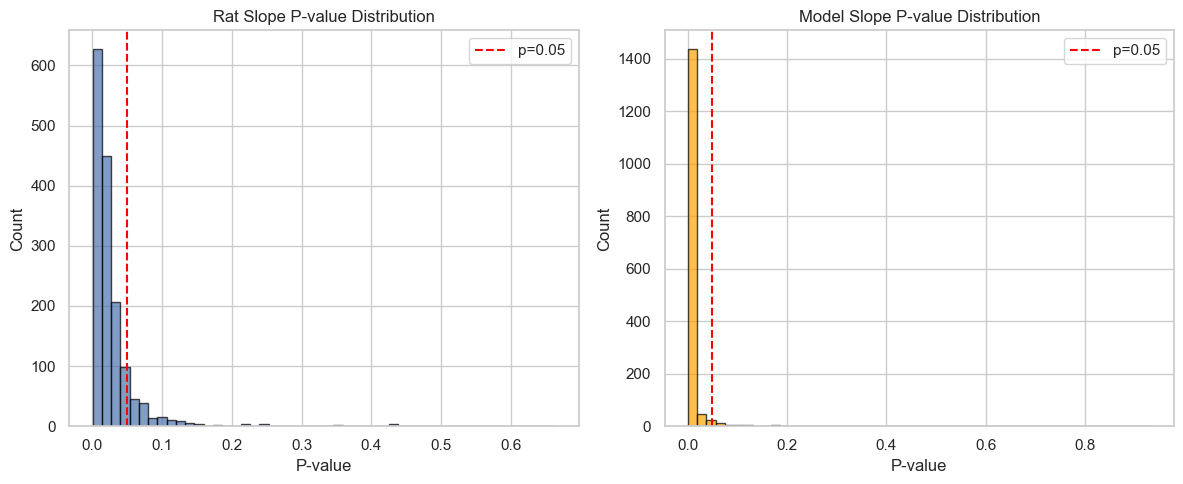

Rat: 1358/1550 slopes have p < 0.05
Model: 1502/1550 slopes have p < 0.05


In [5]:
# store p-values
rat_pvalues = []
model_pvalues = []

# loop through all fit files
fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))

for file in fit_files:
    mat = loadmat(file, struct_as_record=False, squeeze_me=True)
    data = mat['BestFit_Folds']
    
    for fold_idx in range(5):
        fold = data[fold_idx]
        
        # get data
        bestfit = fold.BestFit
        model_wait_times = bestfit.Train.WTOpt
        train_data = fold.ratTrial_TrainFold
        
        df_train = pd.DataFrame({
            'reward': train_data.reward,
            'block': train_data.block,
            'wait_time': train_data.wait_time,
            'model_wait_time': model_wait_times,
            'optout': train_data.optout,
            'vios': train_data.vios,
        })
        
        df_filtered = apply_valid_trial_filter(df_train)
        
        # map rewards
        unique_rewards = sorted(df_filtered['reward'].unique())
        if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
            reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
            df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
        
        mixed_data = df_filtered[df_filtered['block'] == 1]
        reward_sizes = [5, 10, 20, 40, 80]
        
        # rat p-value
        rat_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['wait_time'].mean()
            rat_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(rat_mean_wt)
        if np.sum(valid_idx) > 1:
            _, _, _, p_value, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                            np.array(rat_mean_wt)[valid_idx])
            rat_pvalues.append(p_value)
        
        # model p-value
        model_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['model_wait_time'].mean()
            model_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(model_mean_wt)
        if np.sum(valid_idx) > 1:
            _, _, _, p_value, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                            np.array(model_mean_wt)[valid_idx])
            model_pvalues.append(p_value)

# plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# rat p-value distribution
ax1.hist(rat_pvalues, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
ax1.set_xlabel('P-value')
ax1.set_ylabel('Count')
ax1.set_title('Rat Slope P-value Distribution')
ax1.legend()

# model p-value distribution
ax2.hist(model_pvalues, bins=50, alpha=0.7, color='orange', edgecolor='black')
ax2.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
ax2.set_xlabel('P-value')
ax2.set_ylabel('Count')
ax2.set_title('Model Slope P-value Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

# print summary
print(f"Rat: {np.sum(np.array(rat_pvalues) < 0.05)}/{len(rat_pvalues)} slopes have p < 0.05")
print(f"Model: {np.sum(np.array(model_pvalues) < 0.05)}/{len(model_pvalues)} slopes have p < 0.05")

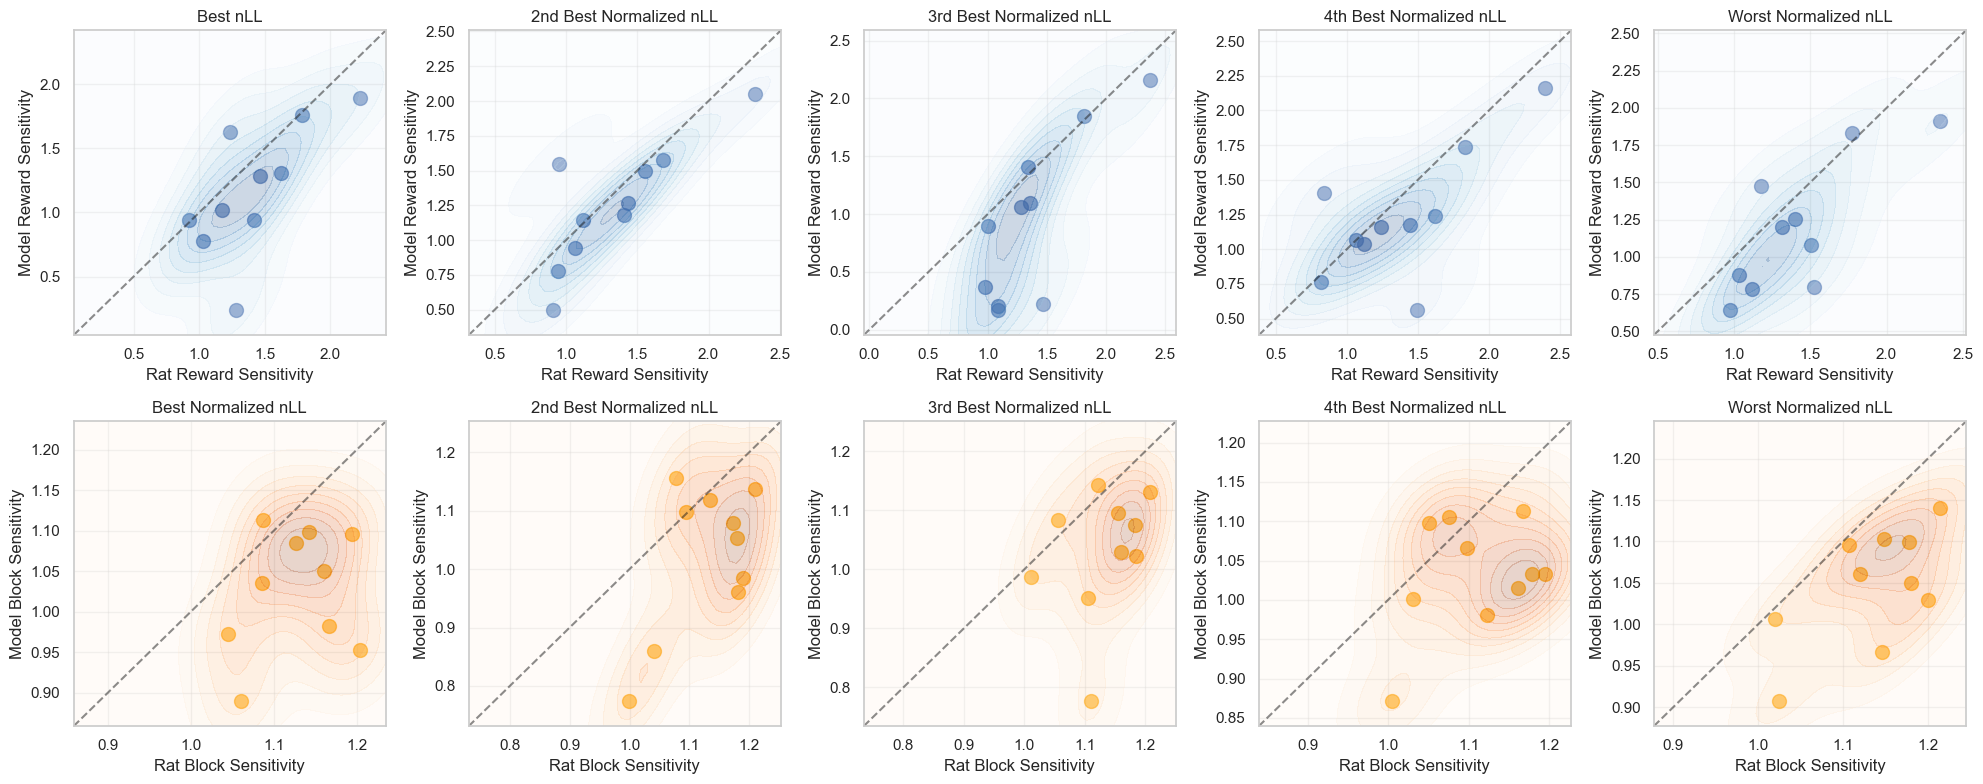

In [6]:
# randomly select 10 rats
fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))
np.random.seed(42)  # for reproducibility
selected_files = np.random.choice(fit_files, min(10, len(fit_files)), replace=False)

# store data for each ranking position
ranked_data = {i: {'rat_rew': [], 'model_rew': [], 'rat_block': [], 'model_block': []} 
               for i in range(5)}

# process each selected rat
for file in selected_files:
    rat_id = os.path.basename(file).split('_')[0]
    
    # load the fit file
    mat = loadmat(file, struct_as_record=False, squeeze_me=True)
    data = mat['BestFit_Folds']
    
    # calculate normalized nLL for each fold
    fold_nlls = []
    fold_stats = []
    
    for fold_idx in range(5):
        fold = data[fold_idx]
        
        # get normalized nLL
        nll_train = fold.nLL_TrainFold
        min_nll = np.min(nll_train)
        train_data = fold.ratTrial_TrainFold
        catch_array = train_data.catch
        wait_time_array = train_data.wait_time
        valid_mask = (catch_array == 1) & (~np.isnan(wait_time_array))
        valid_trials = np.sum(valid_mask)
        normalized_nll = min_nll / valid_trials
        
        # get model wait times
        bestfit = fold.BestFit
        model_wait_times = bestfit.Train.WTOpt
        
        # create dataframe
        df_train = pd.DataFrame({
            'reward': train_data.reward,
            'block': train_data.block,
            'wait_time': train_data.wait_time,
            'model_wait_time': model_wait_times,
            'optout': train_data.optout,
            'vios': train_data.vios,
        })
        
        # apply filtering
        df_filtered = apply_valid_trial_filter(df_train)
        
        # map rewards
        unique_rewards = sorted(df_filtered['reward'].unique())
        if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
            reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
            df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
        
        # calculate rat stats
        mixed_data = df_filtered[df_filtered['block'] == 1]
        reward_sizes = [5, 10, 20, 40, 80]
        
        # rat reward sensitivity
        rat_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['wait_time'].mean()
            rat_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(rat_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(rat_mean_wt)[valid_idx])
            rat_rew_sensitivity = slope
        else:
            rat_rew_sensitivity = np.nan
        
        # rat block sensitivity
        low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        rat_block_sensitivity = low_20 / high_20 if high_20 > 0 else np.nan
        
        # calculate model stats
        model_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['model_wait_time'].mean()
            model_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(model_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(model_mean_wt)[valid_idx])
            model_rew_sensitivity = slope
        else:
            model_rew_sensitivity = np.nan
        
        # model block sensitivity
        model_low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_block_sensitivity = model_low_20 / model_high_20 if model_high_20 > 0 else np.nan
        
        # store results
        fold_nlls.append(normalized_nll)
        fold_stats.append({
            'rat_rew': rat_rew_sensitivity,
            'model_rew': model_rew_sensitivity,
            'rat_block': rat_block_sensitivity,
            'model_block': model_block_sensitivity
        })
    
    # rank folds by normalized nLL (best to worst)
    ranked_indices = np.argsort(fold_nlls)  # lowest to highest normalized nLL
    
    # add stats to appropriate ranking position
    for rank, fold_idx in enumerate(ranked_indices):
        ranked_data[rank]['rat_rew'].append(fold_stats[fold_idx]['rat_rew'])
        ranked_data[rank]['model_rew'].append(fold_stats[fold_idx]['model_rew'])
        ranked_data[rank]['rat_block'].append(fold_stats[fold_idx]['rat_block'])
        ranked_data[rank]['model_block'].append(fold_stats[fold_idx]['model_block'])

# create figure with 5 subplots (2 rows for reward and block sensitivity)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# plot reward sensitivity
for rank in range(5):
    ax = axes[0, rank]
    
    # remove NaN values
    rat_vals = np.array(ranked_data[rank]['rat_rew'])
    model_vals = np.array(ranked_data[rank]['model_rew'])
    valid = ~(np.isnan(rat_vals) | np.isnan(model_vals))
    
    ax.scatter(rat_vals[valid], model_vals[valid], alpha=0.6, s=100)
    
    # add diagonal x=y line
    if np.sum(valid) > 0:
        # Add margin to prevent cutoff
        data_min = min(rat_vals[valid].min(), model_vals[valid].min())
        data_max = max(rat_vals[valid].max(), model_vals[valid].max())
        margin = (data_max - data_min) * 0.1
        lims = [data_min - margin, data_max + margin]
        
        ax.plot(lims, lims, 'k--', alpha=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # add 2D density plot
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(np.vstack([rat_vals[valid], model_vals[valid]]))
        xi, yi = np.meshgrid(np.linspace(lims[0], lims[1], 50),
                             np.linspace(lims[0], lims[1], 50))
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        ax.contourf(xi, yi, zi, levels=10, cmap='Blues', alpha=0.2)
    
    ax.set_xlabel('Rat Reward Sensitivity')
    ax.set_ylabel('Model Reward Sensitivity')
    if rank == 0:
        ax.set_title('Best nLL')
    elif rank == 1:
        ax.set_title('2nd Best Normalized nLL')
    elif rank == 2:
        ax.set_title('3rd Best Normalized nLL')
    elif rank == 3:
        ax.set_title('4th Best Normalized nLL')
    else:
        ax.set_title('Worst Normalized nLL')
    ax.grid(True, alpha=0.3)

# plot block sensitivity
for rank in range(5):
    ax = axes[1, rank]
    
    # remove NaN values
    rat_vals = np.array(ranked_data[rank]['rat_block'])
    model_vals = np.array(ranked_data[rank]['model_block'])
    valid = ~(np.isnan(rat_vals) | np.isnan(model_vals))
    
    ax.scatter(rat_vals[valid], model_vals[valid], alpha=0.6, s=100, color='orange')
    
    # add diagonal x=y line
    if np.sum(valid) > 0:
        # Add margin to prevent cutoff
        data_min = min(rat_vals[valid].min(), model_vals[valid].min())
        data_max = max(rat_vals[valid].max(), model_vals[valid].max())
        margin = (data_max - data_min) * 0.1
        lims = [data_min - margin, data_max + margin]
        
        ax.plot(lims, lims, 'k--', alpha=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # add 2D density plot
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(np.vstack([rat_vals[valid], model_vals[valid]]))
        xi, yi = np.meshgrid(np.linspace(lims[0], lims[1], 50),
                             np.linspace(lims[0], lims[1], 50))
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        ax.contourf(xi, yi, zi, levels=10, cmap='Oranges', alpha=0.2)
    
    ax.set_xlabel('Rat Block Sensitivity')
    ax.set_ylabel('Model Block Sensitivity')
    if rank == 0:
        ax.set_title('Best Normalized nLL')
    elif rank == 1:
        ax.set_title('2nd Best Normalized nLL')
    elif rank == 2:
        ax.set_title('3rd Best Normalized nLL')
    elif rank == 3:
        ax.set_title('4th Best Normalized nLL')
    else:
        ax.set_title('Worst Normalized nLL')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

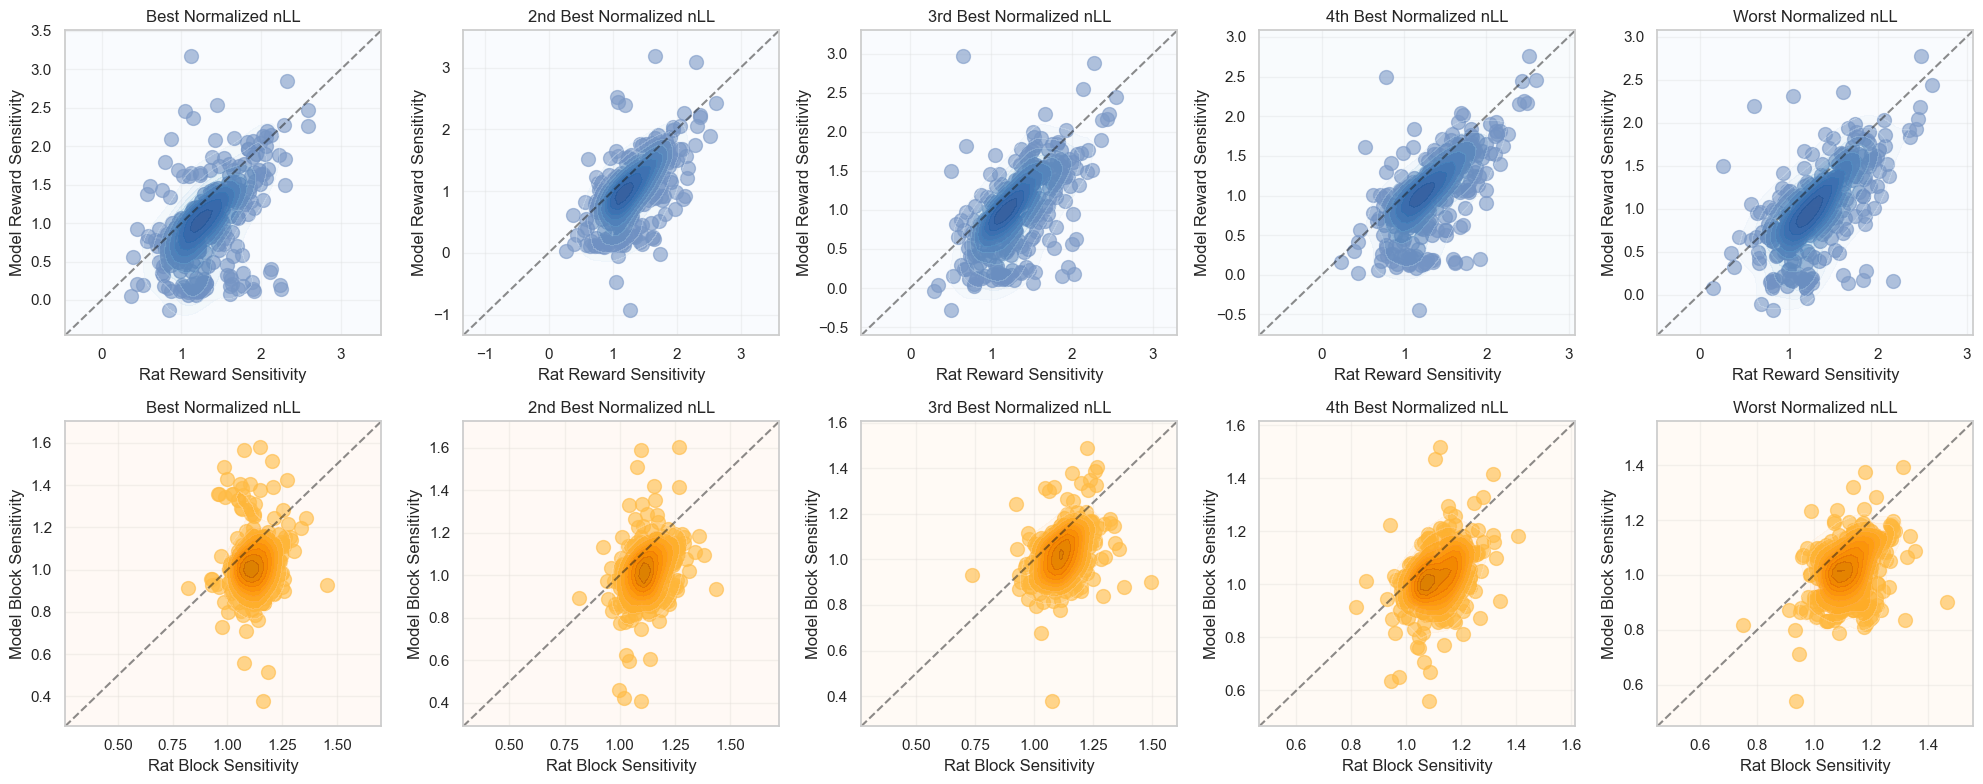

In [9]:
# using all rats
fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))
selected_files = [f for f in fit_files if not any(rat in f for rat in ['M032', 'M026'])]

# store data for each ranking position
ranked_data = {i: {'rat_rew': [], 'model_rew': [], 'rat_block': [], 'model_block': []} 
               for i in range(5)}

# process each selected rat
for file in selected_files:
    rat_id = os.path.basename(file).split('_')[0]
    
    # load the fit file
    mat = loadmat(file, struct_as_record=False, squeeze_me=True)
    data = mat['BestFit_Folds']
    
    # calculate normalized nLL for each fold
    fold_nlls = []
    fold_stats = []
    
    for fold_idx in range(5):
        fold = data[fold_idx]
        
        # get normalized nLL
        nll_train = fold.nLL_TrainFold
        min_nll = np.min(nll_train)
        train_data = fold.ratTrial_TrainFold
        catch_array = train_data.catch
        wait_time_array = train_data.wait_time
        valid_mask = (catch_array == 1) & (~np.isnan(wait_time_array))
        valid_trials = np.sum(valid_mask)
        normalized_nll = min_nll / valid_trials
        
        # get model wait times
        bestfit = fold.BestFit
        model_wait_times = bestfit.Train.WTOpt
        
        # create dataframe
        df_train = pd.DataFrame({
            'reward': train_data.reward,
            'block': train_data.block,
            'wait_time': train_data.wait_time,
            'model_wait_time': model_wait_times,
            'optout': train_data.optout,
            'vios': train_data.vios,
        })
        
        # apply filtering
        df_filtered = apply_valid_trial_filter(df_train)
        
        # map rewards
        unique_rewards = sorted(df_filtered['reward'].unique())
        if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
            reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
            df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
        
        # calculate rat stats
        mixed_data = df_filtered[df_filtered['block'] == 1]
        reward_sizes = [5, 10, 20, 40, 80]
        
        # rat reward sensitivity
        rat_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['wait_time'].mean()
            rat_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(rat_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(rat_mean_wt)[valid_idx])
            rat_rew_sensitivity = slope
        else:
            rat_rew_sensitivity = np.nan
        
        # rat block sensitivity
        low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['wait_time'].mean()
        rat_block_sensitivity = low_20 / high_20 if high_20 > 0 else np.nan
        
        # calculate model stats
        model_mean_wt = []
        for rew in reward_sizes:
            wt = mixed_data[mixed_data['reward'] == rew]['model_wait_time'].mean()
            model_mean_wt.append(wt)
        
        valid_idx = ~np.isnan(model_mean_wt)
        if np.sum(valid_idx) > 1:
            slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                          np.array(model_mean_wt)[valid_idx])
            model_rew_sensitivity = slope
        else:
            model_rew_sensitivity = np.nan
        
        # model block sensitivity
        model_low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
        model_block_sensitivity = model_low_20 / model_high_20 if model_high_20 > 0 else np.nan
        
        # store results
        fold_nlls.append(normalized_nll)
        fold_stats.append({
            'rat_rew': rat_rew_sensitivity,
            'model_rew': model_rew_sensitivity,
            'rat_block': rat_block_sensitivity,
            'model_block': model_block_sensitivity
        })
    
    # rank folds by normalized nLL (best to worst)
    ranked_indices = np.argsort(fold_nlls)  # lowest to highest normalized nLL
    
    # add stats to appropriate ranking position
    for rank, fold_idx in enumerate(ranked_indices):
        ranked_data[rank]['rat_rew'].append(fold_stats[fold_idx]['rat_rew'])
        ranked_data[rank]['model_rew'].append(fold_stats[fold_idx]['model_rew'])
        ranked_data[rank]['rat_block'].append(fold_stats[fold_idx]['rat_block'])
        ranked_data[rank]['model_block'].append(fold_stats[fold_idx]['model_block'])

# create figure with 5 subplots (2 rows for reward and block sensitivity)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# plot reward sensitivity
for rank in range(5):
    ax = axes[0, rank]
    
    # remove NaN values
    rat_vals = np.array(ranked_data[rank]['rat_rew'])
    model_vals = np.array(ranked_data[rank]['model_rew'])
    valid = ~(np.isnan(rat_vals) | np.isnan(model_vals))
    
    ax.scatter(rat_vals[valid], model_vals[valid], alpha=0.6, s=100)
    
    # add diagonal x=y line
    if np.sum(valid) > 0:
        # add margin to prevent cutoff
        data_min = min(rat_vals[valid].min(), model_vals[valid].min())
        data_max = max(rat_vals[valid].max(), model_vals[valid].max())
        margin = (data_max - data_min) * 0.1
        lims = [data_min - margin, data_max + margin]
        
        ax.plot(lims, lims, 'k--', alpha=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # add 2D density plot
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(np.vstack([rat_vals[valid], model_vals[valid]]))
        xi, yi = np.meshgrid(np.linspace(lims[0], lims[1], 50),
                             np.linspace(lims[0], lims[1], 50))
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        ax.contourf(xi, yi, zi, levels=10, cmap='Blues', alpha=0.3)
    
    ax.set_xlabel('Rat Reward Sensitivity')
    ax.set_ylabel('Model Reward Sensitivity')
    if rank == 0:
        ax.set_title('Best Normalized nLL')
    elif rank == 1:
        ax.set_title('2nd Best Normalized nLL')
    elif rank == 2:
        ax.set_title('3rd Best Normalized nLL')
    elif rank == 3:
        ax.set_title('4th Best Normalized nLL')
    else:
        ax.set_title('Worst Normalized nLL')
    ax.grid(True, alpha=0.3)

# plot block sensitivity
for rank in range(5):
    ax = axes[1, rank]
    
    # remove NaN values
    rat_vals = np.array(ranked_data[rank]['rat_block'])
    model_vals = np.array(ranked_data[rank]['model_block'])
    valid = ~(np.isnan(rat_vals) | np.isnan(model_vals))
    
    ax.scatter(rat_vals[valid], model_vals[valid], alpha=0.6, s=100, color='orange')
    
    # add diagonal x=y line
    if np.sum(valid) > 0:
        # Add margin to prevent cutoff
        data_min = min(rat_vals[valid].min(), model_vals[valid].min())
        data_max = max(rat_vals[valid].max(), model_vals[valid].max())
        margin = (data_max - data_min) * 0.1
        lims = [data_min - margin, data_max + margin]
        
        ax.plot(lims, lims, 'k--', alpha=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # add 2D density plot
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(np.vstack([rat_vals[valid], model_vals[valid]]))
        xi, yi = np.meshgrid(np.linspace(lims[0], lims[1], 50),
                             np.linspace(lims[0], lims[1], 50))
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        ax.contourf(xi, yi, zi, levels=10, cmap='Oranges', alpha=0.3)
    
    ax.set_xlabel('Rat Block Sensitivity')
    ax.set_ylabel('Model Block Sensitivity')
    if rank == 0:
        ax.set_title('Best Normalized nLL')
    elif rank == 1:
        ax.set_title('2nd Best Normalized nLL')
    elif rank == 2:
        ax.set_title('3rd Best Normalized nLL')
    elif rank == 3:
        ax.set_title('4th Best Normalized nLL')
    else:
        ax.set_title('Worst Normalized nLL')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# store best fold data for each rat
best_fold_data = []

fit_files = glob.glob(os.path.join(model_dir, "*_Fits_NFoldCV.mat"))

for file in fit_files:
    rat_id = os.path.basename(file).split('_')[0]
    
    mat = loadmat(file, struct_as_record=False, squeeze_me=True)
    data = mat['BestFit_Folds']
    
    # find best fold (lowest normalized nLL)
    best_nll = float('inf')
    best_fold_stats = None
    
    for fold_idx in range(5):
        fold = data[fold_idx]
        
        # get normalized nLL
        nll_train = fold.nLL_TrainFold
        min_nll = np.min(nll_train)
        train_data = fold.ratTrial_TrainFold
        catch_array = train_data.catch
        wait_time_array = train_data.wait_time
        valid_mask = (catch_array == 1) & (~np.isnan(wait_time_array))
        valid_trials = np.sum(valid_mask)
        normalized_nll = min_nll / valid_trials
        
        if normalized_nll < best_nll:
            best_nll = normalized_nll
            
            # get model wait times
            bestfit = fold.BestFit
            model_wait_times = bestfit.Train.WTOpt
            
            # calculate stats for this fold
            df_train = pd.DataFrame({
                'reward': train_data.reward,
                'block': train_data.block,
                'wait_time': train_data.wait_time,
                'model_wait_time': model_wait_times,
                'optout': train_data.optout,
                'vios': train_data.vios,
            })
            
            df_filtered = apply_valid_trial_filter(df_train)
            
            # map rewards
            unique_rewards = sorted(df_filtered['reward'].unique())
            if any(r in [4, 8, 16, 32, 64] for r in unique_rewards):
                reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
                df_filtered['reward'] = df_filtered['reward'].replace(reward_map)
            
            # calculate stats
            mixed_data = df_filtered[df_filtered['block'] == 1]
            reward_sizes = [5, 10, 20, 40, 80]
            
            # rat reward sensitivity
            rat_mean_wt = []
            for rew in reward_sizes:
                wt = mixed_data[mixed_data['reward'] == rew]['wait_time'].mean()
                rat_mean_wt.append(wt)
            
            valid_idx = ~np.isnan(rat_mean_wt)
            if np.sum(valid_idx) > 1:
                slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                              np.array(rat_mean_wt)[valid_idx])
                rat_rew_sensitivity = slope
            else:
                rat_rew_sensitivity = np.nan
            
            # model reward sensitivity
            model_mean_wt = []
            for rew in reward_sizes:
                wt = mixed_data[mixed_data['reward'] == rew]['model_wait_time'].mean()
                model_mean_wt.append(wt)
            
            valid_idx = ~np.isnan(model_mean_wt)
            if np.sum(valid_idx) > 1:
                slope, _, _, _, _ = linregress(np.log(np.array(reward_sizes)[valid_idx]), 
                                              np.array(model_mean_wt)[valid_idx])
                model_rew_sensitivity = slope
            else:
                model_rew_sensitivity = np.nan
            
            # rat block sensitivity
            low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['wait_time'].mean()
            high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['wait_time'].mean()
            rat_block_sensitivity = low_20 / high_20 if high_20 > 0 else np.nan
            
            # model block sensitivity
            model_low_20 = df_filtered[(df_filtered['block'] == 3) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
            model_high_20 = df_filtered[(df_filtered['block'] == 2) & (df_filtered['reward'] == 20)]['model_wait_time'].mean()
            model_block_sensitivity = model_low_20 / model_high_20 if model_high_20 > 0 else np.nan
            
            best_fold_stats = {
                'rat_id': rat_id,
                'rat_rew': rat_rew_sensitivity,
                'rat_block': rat_block_sensitivity,
                'model_rew': model_rew_sensitivity,
                'model_block': model_block_sensitivity
            }
    
    if best_fold_stats:
        best_fold_data.append(best_fold_stats)

# convert to dataframe
df_best = pd.DataFrame(best_fold_data)

# find outliers
print("Model Reward Sensitivity Outliers:")
model_rew_outliers = df_best[df_best['model_rew'] < -1].sort_values('model_rew')
for _, row in model_rew_outliers.iterrows():
    print(f"  {row['rat_id']}: rat_rew={row['rat_rew']:.2f}, model_rew={row['model_rew']:.2f}")

print("\nModel Block Sensitivity Outliers:")
model_block_outliers = df_best[df_best['model_block'] > 4].sort_values('model_block', ascending=False)
for _, row in model_block_outliers.iterrows():
    print(f"  {row['rat_id']}: rat_block={row['rat_block']:.2f}, model_block={row['model_block']:.2f}")

print(f"\nThe outlier rats are: {set(list(model_rew_outliers['rat_id']) + list(model_block_outliers['rat_id']))}")

Model Reward Sensitivity Outliers:
  M032: rat_rew=1.78, model_rew=-4.17
  M026: rat_rew=1.53, model_rew=-2.19

Model Block Sensitivity Outliers:
  M032: rat_block=1.13, model_block=5.97
  M026: rat_block=0.91, model_block=5.00

The outlier rats are: {'M026', 'M032'}
